In [15]:
import numpy as np
import pandas as pd

data = pd.read_csv('bank-full.csv', sep=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [16]:
### Need only other columns except 'loan'. So delete the column
del data['loan']
data.head()

,age,job,marital,education,default,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [17]:
### Encode the traget variable yes/no to 1/0
data.y = data.y.map({'yes':1, 'no':0})

In [18]:
from sklearn.model_selection import train_test_split
from IPython.display import display

SEED  = 1
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

display(len(df_full_train))
display(len(df_train))
display(len(df_val))
display(len(df_test))

36168

27126

9042

9043

In [19]:
### Extract the target variables for Train, Val, Test
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train["y"]
del df_val["y"]
del df_test["y"]

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

balance,
day,
duration,
previous

In [20]:
df_train.select_dtypes(exclude=object)

,age,balance,day,duration,campaign,pdays,previous
14137,56,40,11,123,2,-1,0
33506,33,4790,20,137,1,272,2
27524,32,392,21,148,2,-1,0
34058,40,2129,30,452,1,-1,0
25922,54,1180,19,394,2,-1,0
...,...,...,...,...,...,...,...
22520,32,195,22,239,2,-1,0
26678,52,3720,20,114,2,-1,0
4964,52,289,21,45,13,-1,0
20083,32,312,11,67,4,-1,0


In [23]:
from sklearn.metrics import roc_auc_score
numerical = ['age',	'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

auc_numerical = pd.DataFrame(columns=['Variable', 'AUC'])
for col in numerical:
    auc = roc_auc_score(y_score=df_train[col], y_true=y_train)
    if auc < 0.5:
        auc = roc_auc_score(y_score=-df_train[col], y_true=y_train)
    auc_numerical.loc[len(auc_numerical)] = [col, auc]

auc_numerical

,Variable,AUC
0,age,0.512186
1,balance,0.588831
2,day,0.525958
3,duration,0.814700
4,campaign,0.571454
5,pdays,0.590128
6,previous,0.598565


#### Answer 1: Duration has highest AUC

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.69,
0.79,
0.89,
0.99

In [26]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

SEED = 1

dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)


np.float64(0.9010604972512507)

Answer 2 : 0.90 --> Select 0.89

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.265,
0.465,
0.665,
0.865

In [27]:
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
## Precision = TP/(TP+FP)
## Recall = TP/(TP+FN)

scores = []

thresholds = np.arange(start=0.0, stop=1.0, step=0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    prec = tp/(tp+fp)
    recall = tp/(tp+fn)

    scores.append((t, tp, tn, fp, fn, prec, recall))

columns = ['threshold', 'tp', 'tn', 'fp', 'fn', 'prec', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores


,threshold,tp,tn,fp,fn,prec,recall
0,0.00,1098,0,7944,0,0.121433,1.000000
1,0.01,1095,859,7085,3,0.133863,0.997268
2,0.02,1094,2123,5821,4,0.158207,0.996357
3,0.03,1086,3159,4785,12,0.184977,0.989071
4,0.04,1073,4114,3830,25,0.218846,0.977231
...,...,...,...,...,...,...,...
95,0.95,40,7925,19,1058,0.677966,0.036430
96,0.96,33,7927,17,1065,0.660000,0.030055
97,0.97,24,7930,14,1074,0.631579,0.021858
98,0.98,20,7934,10,1078,0.666667,0.018215


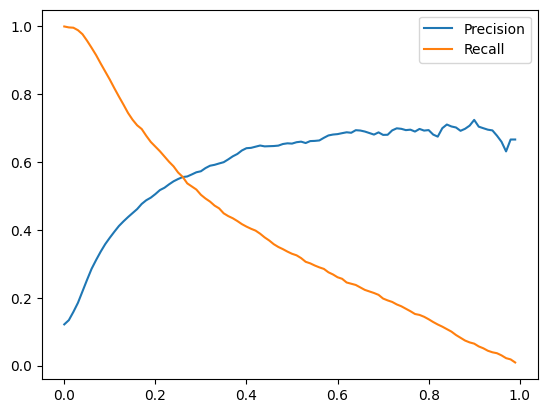

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores.threshold, df_scores.prec, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.legend()

### Answer 3: Precision & Recall curve intersect at threshold = 0.265

### Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [29]:
df_scores['f1'] = 2*df_scores['prec']*df_scores['recall']/(df_scores['prec'] + df_scores['recall'])

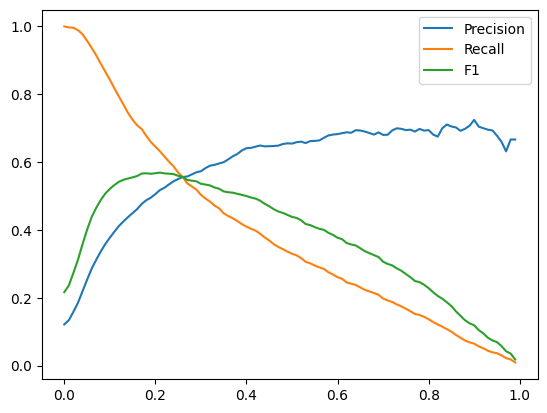

In [30]:
plt.plot(df_scores.threshold, df_scores.prec, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.plot(df_scores.threshold, df_scores.f1, label='F1')
plt.legend()

### Answer 4: 0.22